In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale,  StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split


from scipy.stats import boxcox

import os

pd.set_option('display.max_columns', None)
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def replace_low_freq(df, threshold=100, replacement='other'):
    s = df.stack()
    c = s.value_counts()
    m = pd.Series(replacement, c.index[c <= threshold])
    return s.replace(m).unstack()

In [3]:
def findSkewedColumns(columns, df, thresholdPercent = 80, displayValueCounts = False):
    skewedColumns = []
    for col in columns:
        valueCounts = (100*df[col].value_counts(normalize=True)).to_dict()
        if(displayValueCounts):
            print(col)
            print(valueCounts)
        abovethreshold = list(filter(lambda x:x>thresholdPercent, valueCounts.values()))
        if(len(abovethreshold)>0):
            skewedColumns.append(col)
    return skewedColumns

In [4]:
pricingInfo = pd.read_csv('train.csv')
originalCol = pricingInfo.columns
pricingInfo.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [5]:
pricingInfo.shape

(1460, 81)

In [6]:
pricingInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Inspecting and handling null values

In [7]:
# inspect null values
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageCond       5.55
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

In [8]:
# droping columns with >80% of null values and id column
pricingInfo.drop(['Id','PoolQC', 'Alley', 'Fence', 'MiscFeature'], axis=1, inplace=True)

#### investigate FireplaceQu

In [9]:
pricingInfo.FireplaceQu.value_counts(normalize=True, dropna=False) 

NaN    0.472603
Gd     0.260274
TA     0.214384
Fa     0.022603
Ex     0.016438
Po     0.013699
Name: FireplaceQu, dtype: float64

In [10]:
pricingInfo.FireplaceQu.fillna('NoFirePlace', inplace=True)

In [11]:
pricingInfo.FireplaceQu.value_counts(normalize=True, dropna=False) 

NoFirePlace    0.472603
Gd             0.260274
TA             0.214384
Fa             0.022603
Ex             0.016438
Po             0.013699
Name: FireplaceQu, dtype: float64

#### investigate BsmtCond

In [12]:
pricingInfo.BsmtCond.value_counts(normalize=True, dropna=False) 

TA     0.897945
Gd     0.044521
Fa     0.030822
NaN    0.025342
Po     0.001370
Name: BsmtCond, dtype: float64

In [13]:
pricingInfo.BsmtCond.fillna('NoBasement', inplace=True)

In [14]:
pricingInfo.BsmtCond.value_counts(normalize=True, dropna=False) 

TA            0.897945
Gd            0.044521
Fa            0.030822
NoBasement    0.025342
Po            0.001370
Name: BsmtCond, dtype: float64

In [15]:
#garage type
pricingInfo.GarageType.fillna('NoGarage', inplace=True)

In [16]:
#garage condition
pricingInfo.GarageCond.fillna('NoGarage', inplace=True)

In [17]:
#garage condition
pricingInfo.GarageFinish.fillna('NoGarage', inplace=True)

In [18]:
#garage condition
pricingInfo.GarageQual.fillna('NoGarage', inplace=True)

In [19]:
#basement condition
pricingInfo.BsmtFinType1.fillna('NoBasement', inplace=True)

In [20]:
#basement condition
pricingInfo.BsmtFinType2.fillna('NoBasement', inplace=True)

In [21]:
#basement condition
pricingInfo.BsmtQual.fillna('NoBasement', inplace=True)

In [22]:
#basement condition
pricingInfo.BsmtExposure.fillna('NoBasement', inplace=True)

In [23]:
pricingInfo.MasVnrType.value_counts(dropna=False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

In [24]:
## investigate relation between nulls of masvnrType and masvnrares
pricingInfo.loc[((pricingInfo.MasVnrType.isnull()) & (pricingInfo.MasVnrArea.notna()))]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


#### Observation
MasVnrArea is null only if MasVnrType is null. which means whem MasVnrArea is not available. hence area can be set to 0.

In [25]:
#masvnrtyp condition
pricingInfo.MasVnrType.fillna(pricingInfo.MasVnrType.mode()[0], inplace=True)
pricingInfo.MasVnrArea.fillna(0, inplace=True)

In [26]:
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

LotFrontage    17.74
GarageYrBlt     5.55
Electrical      0.07
dtype: float64

In [27]:
pricingInfo.GarageYrBlt.describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [28]:
# garage can either be build during initial construction or during remodaling. We are making an assumption here. 
# pricingInfo.loc[pricingInfo.GarageYrBlt.isnull(), 'GarageYrBlt'] = pricingInfo['YearRemodAdd']

In [29]:
pricingInfo.Electrical.value_counts(dropna=False)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

#### Observation
1 missing value. Hence can be dropped. 

In [30]:
print(pricingInfo.shape)
pricingInfo = pricingInfo[pricingInfo.Electrical.notna()]
print(pricingInfo.shape)

(1460, 76)
(1459, 76)


In [31]:
#LotFrontage    
pricingInfo.LotFrontage.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1200.000000
mean       70.047500
std        24.294727
min        21.000000
10%        43.900000
25%        59.000000
30%        60.000000
50%        69.000000
75%        80.000000
80%        85.000000
90%        96.000000
95%       107.000000
97%       120.000000
98%       124.080000
100%      313.000000
max       313.000000
Name: LotFrontage, dtype: float64

#### Observation
Mean and meadian are approximately same hence any one can be used to impute. We are using mean as of now

In [32]:
pricingInfo.LotFrontage.fillna(pricingInfo.LotFrontage.mean(), inplace=True)

In [33]:
#investigate nulls again
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

GarageYrBlt    5.55
dtype: float64

### Creating derived variables from year variables

In [34]:
import datetime
def convertToAge(value , columnName):
    now = datetime.datetime.now()
    year = now.year
    if np.isnan(value):
        return -1
    else:
        return year - round(value)


In [35]:
# 1. YearBuilt
pricingInfo['PropertyAge'] = pricingInfo.YearBuilt.apply(convertToAge, args=['YearBuilt'])
pricingInfo.loc[:, ['PropertyAge', 'YearBuilt']].head() 

,PropertyAge,YearBuilt
0,17,2003
1,44,1976
2,19,2001
3,105,1915
4,20,2000


In [36]:
# 2. YearRemodAdd
pricingInfo['YearsRemodel'] = pricingInfo.YearRemodAdd.apply(convertToAge, args=['YearRemodAdd'])
pricingInfo.loc[:, ['YearsRemodel', 'YearRemodAdd']].head()

,YearsRemodel,YearRemodAdd
0,17,2003
1,44,1976
2,18,2002
3,50,1970
4,20,2000


In [37]:
# 3.Yr Sold
pricingInfo['YearsSinceLastSold'] = pricingInfo.YrSold.apply(convertToAge, args=['YrSold'])
pricingInfo.loc[:, ['YearsSinceLastSold', 'YrSold']].head() 

,YearsSinceLastSold,YrSold
0,12,2008
1,13,2007
2,12,2008
3,14,2006
4,12,2008


In [38]:
# 4. GarageYrBlt
pricingInfo['YearsSinceGarage'] = pricingInfo.GarageYrBlt.apply(convertToAge, args=['GarageYrBlt'])
pricingInfo.loc[:, ['YearsSinceGarage', 'GarageYrBlt']].head() 

,YearsSinceGarage,GarageYrBlt
0,17,2003.0
1,44,1976.0
2,19,2001.0
3,22,1998.0
4,20,2000.0


## Exploratory data analysis

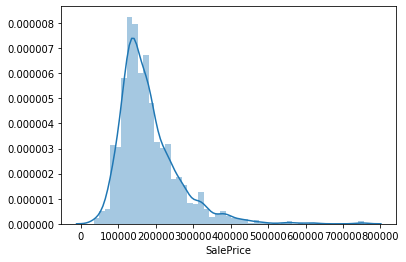

In [39]:
sns.distplot(pricingInfo.SalePrice)

#### Observation
We see that the distribution has outliers and is skewed. We will try to convert this to gausian form

In [40]:
pricingInfo[pricingInfo.SalePrice<=0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PropertyAge,YearsRemodel,YearsSinceLastSold,YearsSinceGarage


In [41]:
from numpy import exp

# power transform - logarithmic transformation
data = boxcox(pricingInfo.SalePrice, 0)
pricingInfo.SalePrice = data

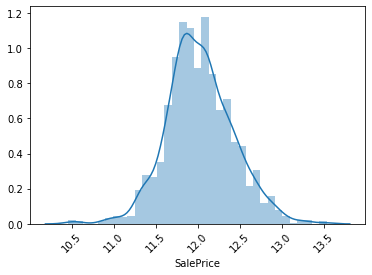

In [42]:
plt.xticks(rotation=45)
sns.distplot(pricingInfo.SalePrice)

### Observation
Log transformation converts the target variable to normal form. 

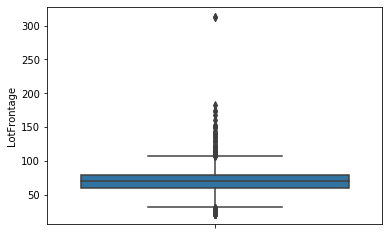

In [43]:
sns.boxplot(x='LotFrontage', data=pricingInfo, orient='v' )

#### Observation
Contains some outliers. Need to be handled.

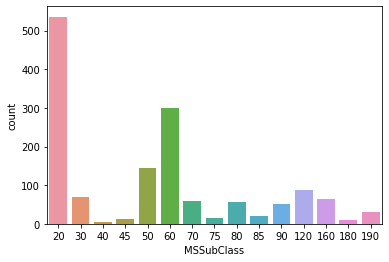

In [44]:
#Type of dwellings in sale
sns.countplot(pricingInfo.MSSubClass)

#### Observation. 
Most of the houses for sale are 1 storey wtih 1946 or above model or 2 story wtih 1946 or above model

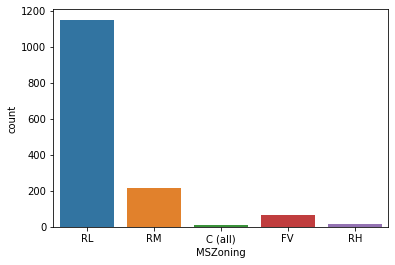

In [45]:
#Areas with number of properties for sale. 
sns.countplot(pricingInfo.MSZoning)

#### Observation
Most of the properties up for sale are in residentaiol areas with low density

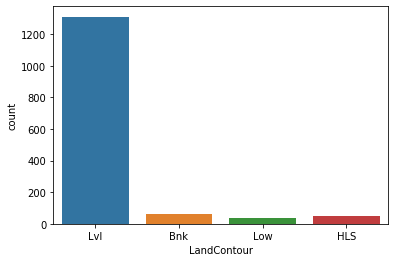

In [46]:
# number of properties for sale based on land conditions
sns.countplot(pricingInfo.LandContour)

In [47]:
pricingInfo.LandContour.value_counts(normalize=True)

Lvl    0.897875
Bnk    0.043180
HLS    0.034270
Low    0.024674
Name: LandContour, dtype: float64

#### Observation
Approx 90% of the values in given data are in level fields. This column is highly skewed.

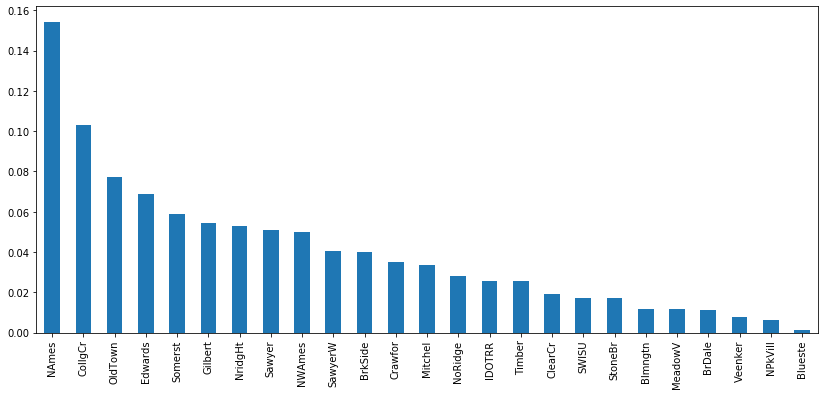

In [48]:
plt.figure(figsize=(14,6))
pricingInfo.Neighborhood.value_counts(normalize=True).plot.bar()

### Observation
North Ames has the highest number of properties up for sale followed by College creek

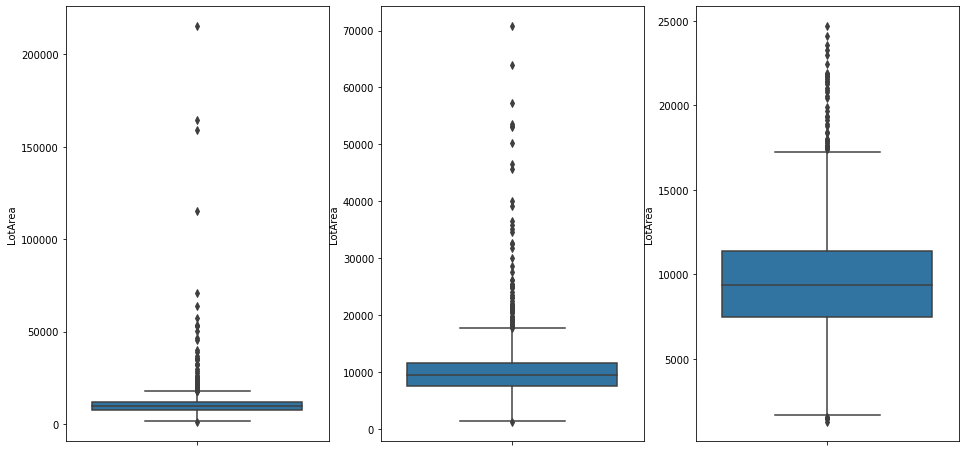

In [49]:
#Lot area distribution
plt.figure(figsize=(16,8))
plt.subplot(1, 3,1)
sns.boxplot(x='LotArea', data=pricingInfo, orient='v')

plt.subplot(1, 3,2)
sns.boxplot(x='LotArea', data=pricingInfo.loc[pricingInfo.LotArea<100000], orient='v')

plt.subplot(1, 3, 3)
sns.boxplot(x='LotArea', data=pricingInfo.loc[pricingInfo.LotArea<25000], orient='v')

In [50]:
pricingInfo.LotArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count      1459.000000
mean      10517.363948
std        9984.666267
min        1300.000000
10%        5000.000000
25%        7549.000000
30%        8063.400000
50%        9477.000000
75%       11603.000000
80%       12206.600000
90%       14388.400000
95%       17402.300000
97%       21576.600000
98%       25255.440000
100%     215245.000000
max      215245.000000
Name: LotArea, dtype: float64

#### Observation - 
95% of the properties have lot area less than 20000. We can consider this column for capping

Text(0, 0.5, 'Percentage')

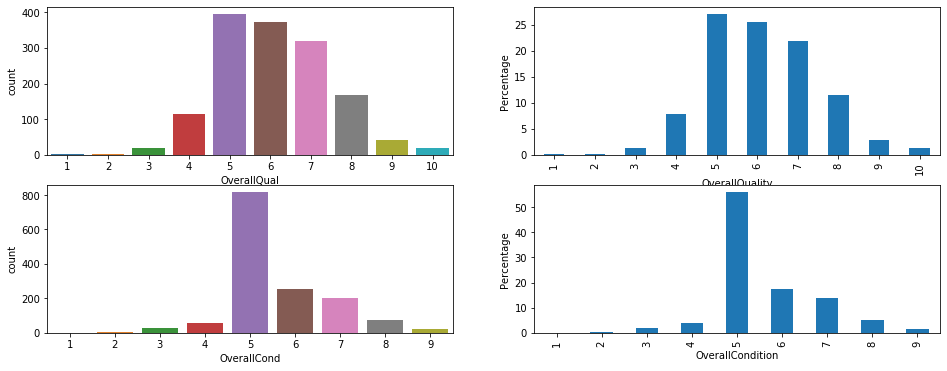

In [51]:
#Quality and condition of available properties
plt.figure(figsize=(16,6))
plt.subplot(2, 2,1)
sns.countplot(pricingInfo.OverallQual)

plt.subplot(2, 2,2)
(100*pricingInfo.OverallQual.value_counts(normalize=True, sort=False)).plot.bar()
plt.xlabel('OverallQuality')
plt.ylabel('Percentage')

plt.subplot(2, 2,3)
sns.countplot(pricingInfo.OverallCond)


plt.subplot(2, 2, 4)
(100*pricingInfo.OverallCond.value_counts(normalize=True, sort=False)).plot.bar()
plt.xlabel('OverallCondition')
plt.ylabel('Percentage')

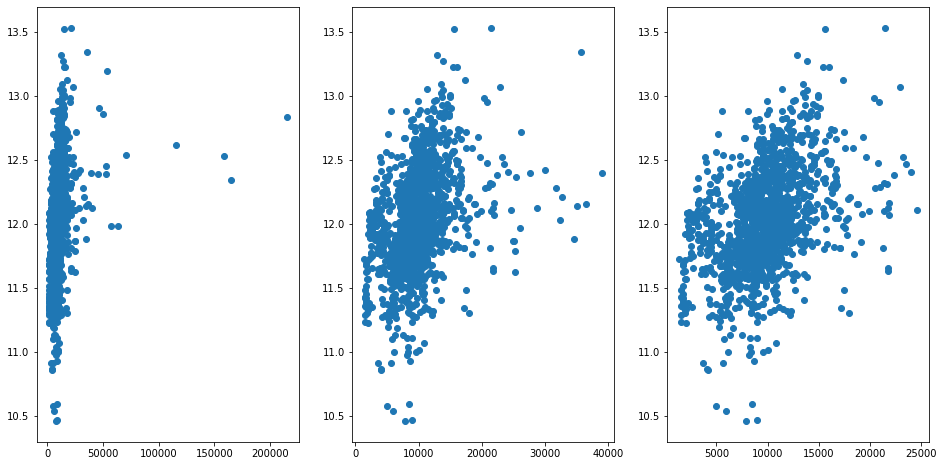

In [52]:
# area vs price
#Lot area distribution
plt.figure(figsize=(16,8))
plt.subplot(1, 3,1)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo)

plt.subplot(1, 3,2)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo.loc[pricingInfo.LotArea<40000])

plt.subplot(1, 3, 3)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo.loc[pricingInfo.LotArea<25000])

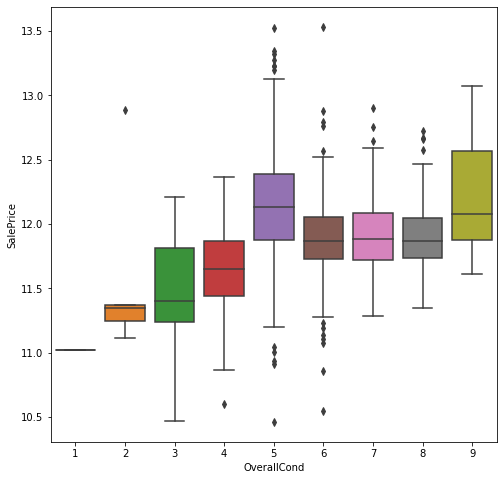

In [53]:
#OVerall condition vs pricing distribution
plt.figure(figsize=(8,8))
sns.boxplot(x='OverallCond',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
median values of properties rated 5 and 9 are almost same. The properties rated 6, 7, 8 have lower median and high values. This column might not have much impact

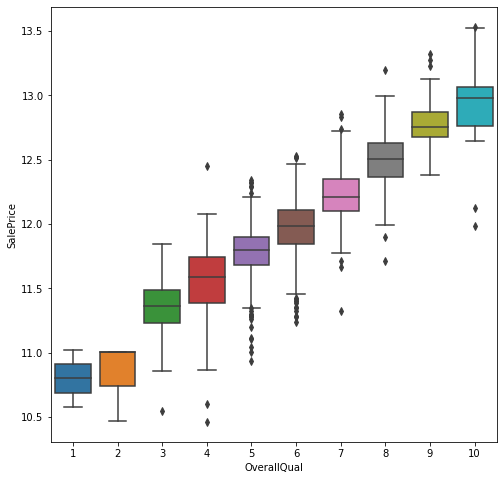

In [54]:
plt.figure(figsize=(8,8))
sns.boxplot(x='OverallQual',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
We see the pricing of the properties keep increasing in a consistent manner as the overall quality of the property improves. Direct impact is evident

In [55]:
pricingInfo.YearBuilt.describe()

count    1459.000000
mean     1971.244003
std        30.199555
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

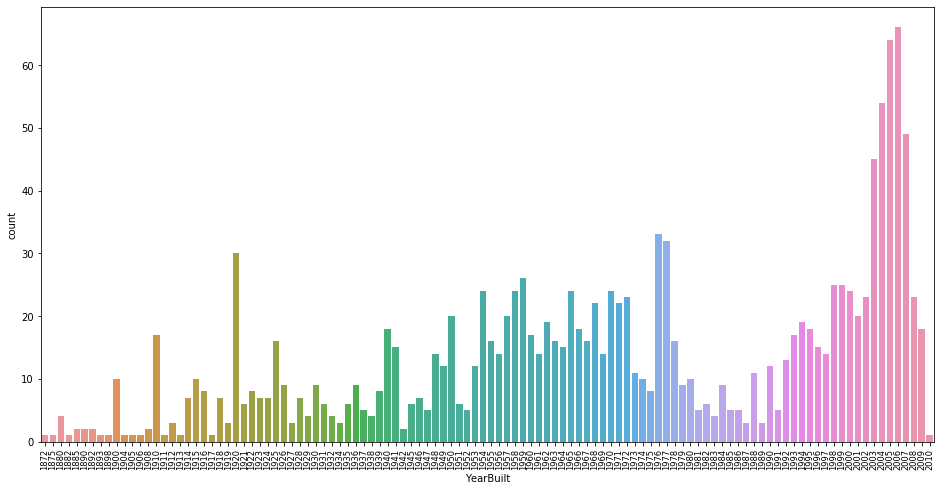

In [56]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.countplot(pricingInfo.YearBuilt)

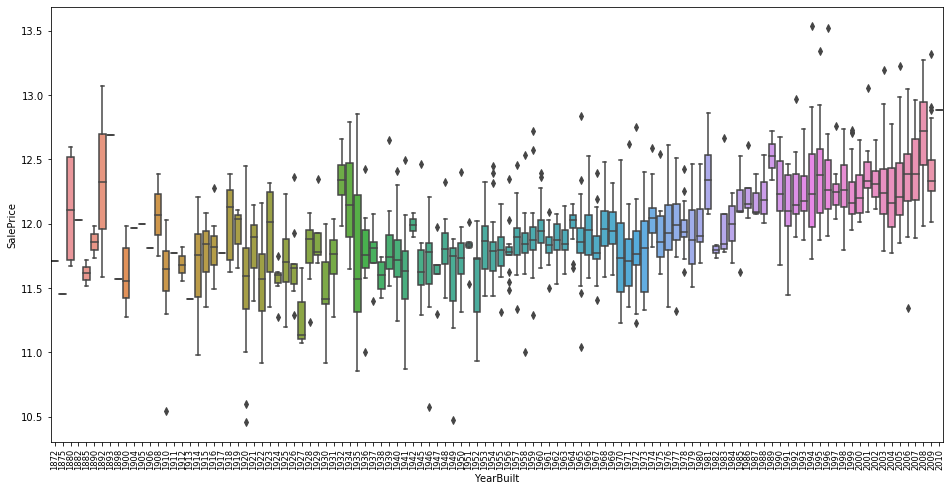

In [57]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YearBuilt',y='SalePrice',data=pricingInfo, orient='v')

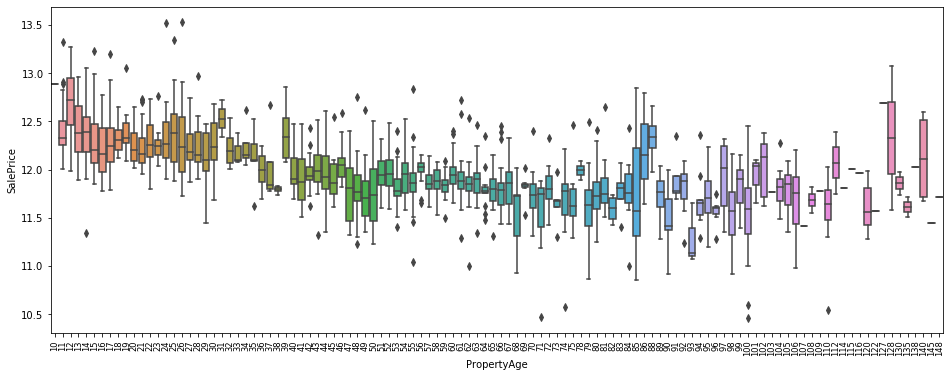

In [58]:
# number of properties by year
plt.figure(figsize=(16,6))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='PropertyAge',y='SalePrice',data=pricingInfo, orient='v')

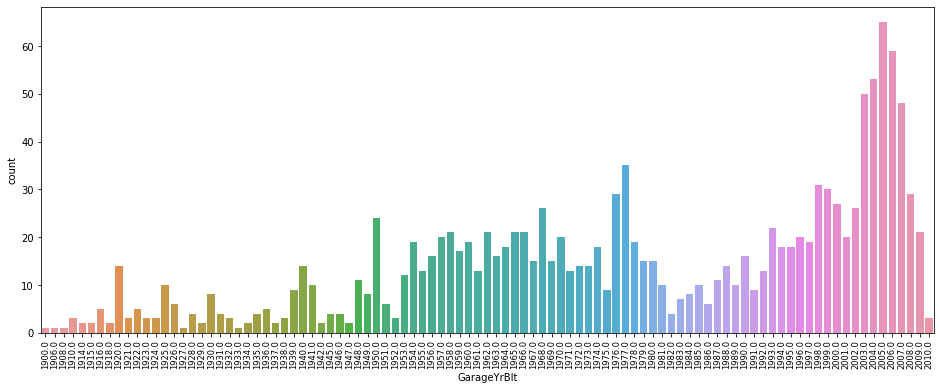

In [59]:
# number of properties by year
plt.figure(figsize=(16,6))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.countplot(pricingInfo.GarageYrBlt)

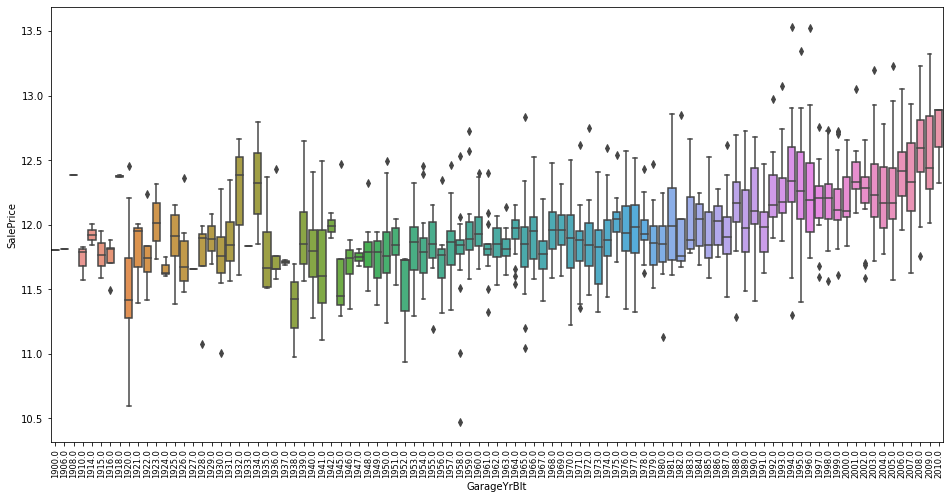

In [60]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='GarageYrBlt',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
no direct relation between year of garage and price. hence dropping the column

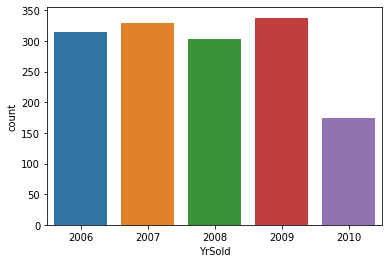

In [61]:
# properties sold by year
# plt.figure(figsize=(8,8))
sns.countplot(x='YrSold', data=pricingInfo)

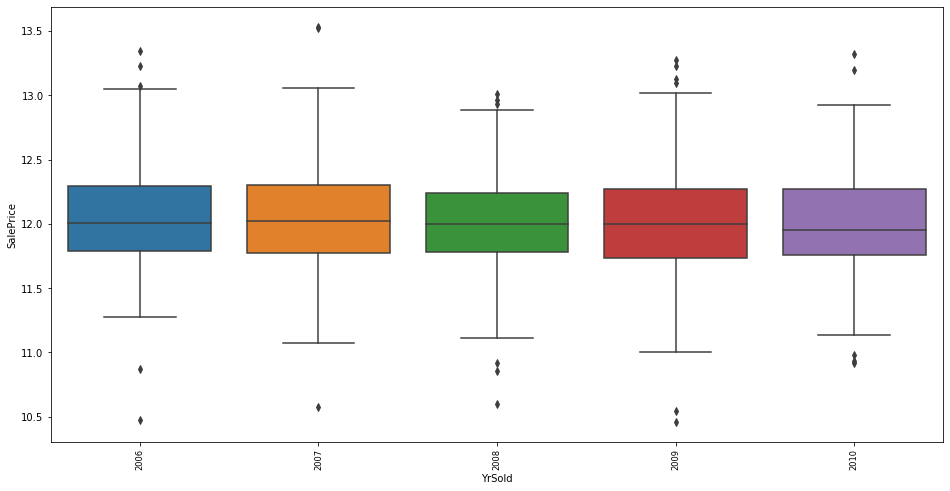

In [62]:
# year sold vs price
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YrSold',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
Market has been stable through years.
- Sales have been consitent
- Price ranges have also been in similar range with slight difference. 
- Since this is not impacting sales we may drop this column

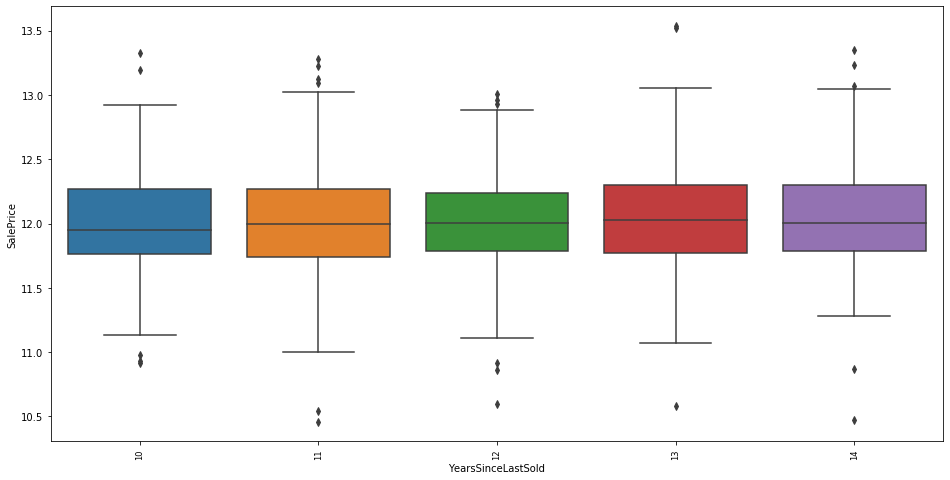

In [63]:
# year sold vs price
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YearsSinceLastSold',y='SalePrice',data=pricingInfo, orient='v')

In [64]:
# inspect MasVnrArea
pricingInfo.MasVnrArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98,.99 ,1])

count    1459.000000
mean      103.187800
std       180.773158
min         0.000000
10%         0.000000
25%         0.000000
30%         0.000000
50%         0.000000
75%       164.500000
80%       205.400000
90%       335.000000
95%       456.000000
97%       573.780000
98%       650.840000
99%       791.360000
100%     1600.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

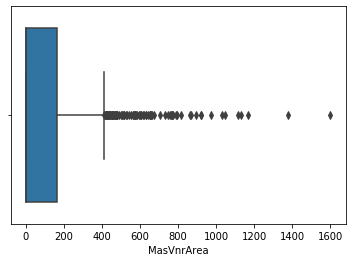

In [65]:
sns.boxplot(x='MasVnrArea', data=pricingInfo)

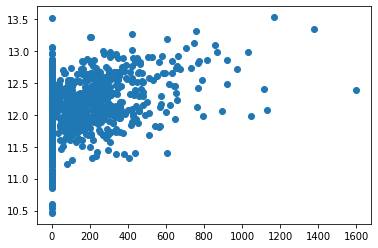

In [66]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=pricingInfo)

#### Observation
Masonry veneer area does not seem to impact pricing. 

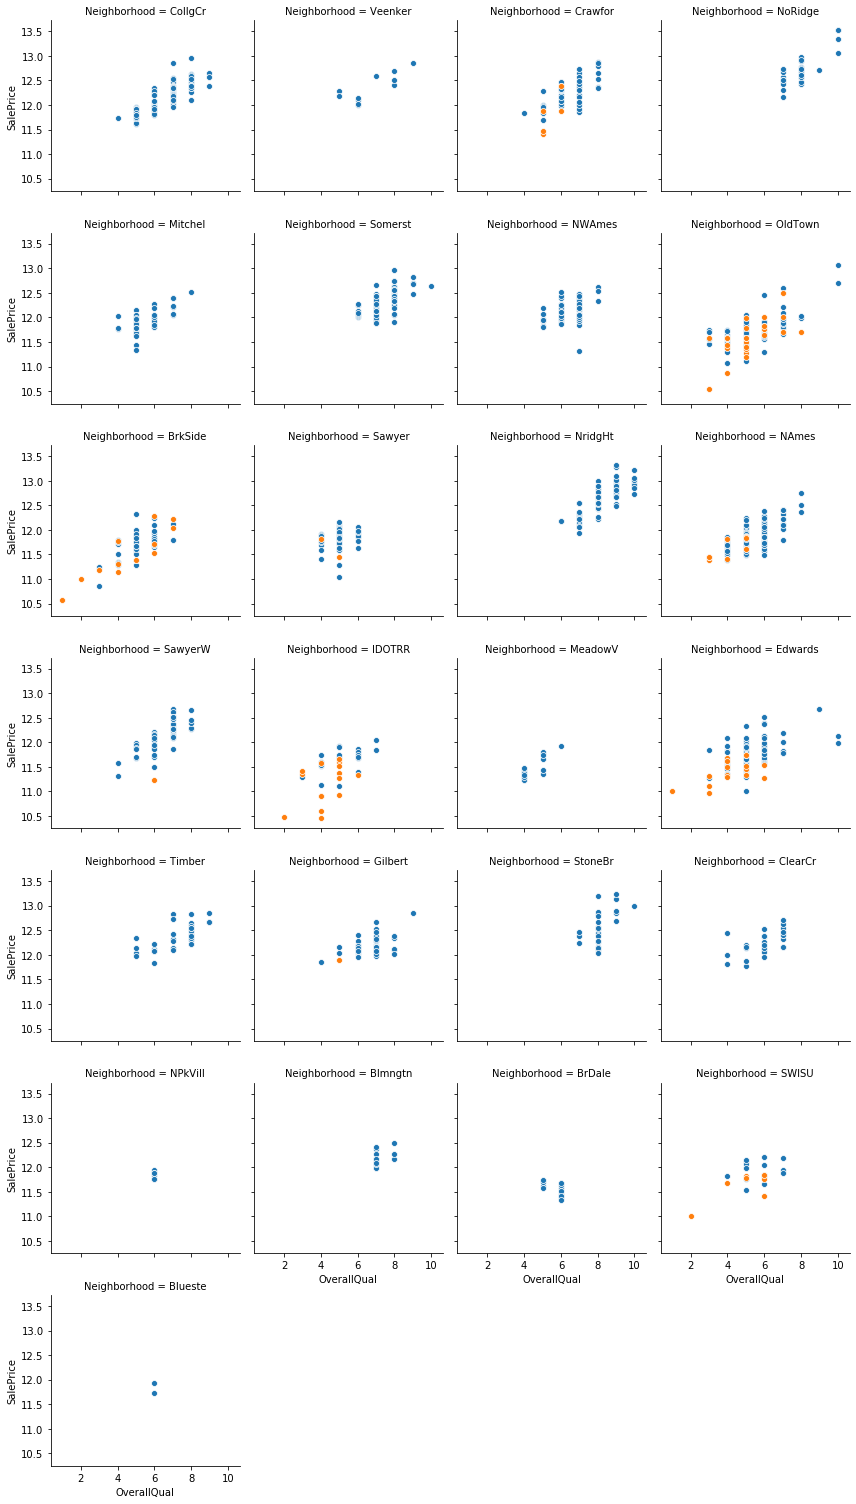

In [67]:
#relation between neighbourhood, central ac, and sale price. 
AreaCentralAirPrice = sns.FacetGrid(data=pricingInfo, col='Neighborhood', hue='CentralAir', col_wrap=4)
AreaCentralAirPrice.map(sns.scatterplot, 'OverallQual', 'SalePrice');

#### Observations
OldTown, BrkSide, Edwards SWISU , IDOTRR seem to have maximum houses without central air conditioning and these tend to have lower prices

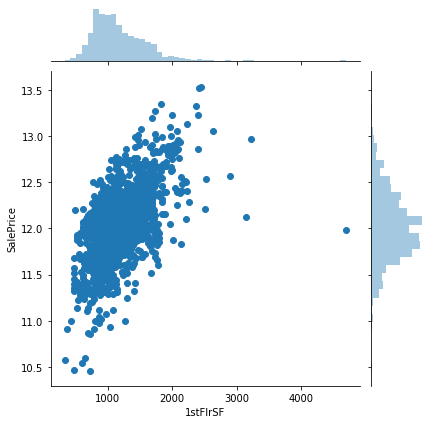

In [68]:
## relationship between 1st floor are and sale price
sns.jointplot(x=pricingInfo['1stFlrSF'], y=pricingInfo['SalePrice']);

#### Observation
As we might expect, with increase in surface area price is increasing. Outliers are present though. 

In [69]:
# these columns have been converted to derived parameters hence can be dropped
pricingInfo.drop(['YearBuilt', 'YearRemodAdd' , 'YrSold' ,'GarageYrBlt'], axis=1, inplace=True)

### Dropping skewed columns

In [70]:
pricingInfo.SaleCondition.value_counts(normalize=True)

Normal     0.820425
Partial    0.085675
Abnorml    0.069225
Family     0.013708
Alloca     0.008225
AdjLand    0.002742
Name: SaleCondition, dtype: float64

In [71]:
pricingInfo.SaleType.value_counts(normalize=True)

WD       0.867718
New      0.083619
COD      0.029472
ConLD    0.006169
ConLI    0.003427
ConLw    0.003427
CWD      0.002742
Oth      0.002056
Con      0.001371
Name: SaleType, dtype: float64

In [72]:
pricingInfo.PavedDrive.value_counts(normalize=True)

Y    0.917752
N    0.061686
P    0.020562
Name: PavedDrive, dtype: float64

In [73]:
pricingInfo.shape

(1459, 76)

In [74]:
## logic to identify any skewed columns
columns = pricingInfo.select_dtypes('object').columns

In [75]:
#skewed columns where 1 value is in over 80% rows. 
skewedColumns = findSkewedColumns(columns, pricingInfo, 80, True)

MSZoning
{'RL': 78.82111034955449, 'RM': 14.941740918437285, 'FV': 4.455106237148732, 'RH': 1.0966415352981496, 'C (all)': 0.6854009595613434}
Street
{'Pave': 99.5887594242632, 'Grvl': 0.411240575736806}
LotShape
{'Reg': 63.331048663468124, 'IR1': 33.17340644276902, 'IR2': 2.8101439342015078, 'IR3': 0.6854009595613434}
LandContour
{'Lvl': 89.78752570253599, 'Bnk': 4.318026045236463, 'HLS': 3.427004797806717, 'Low': 2.467443454420836}
Utilities
{'AllPub': 99.93145990404386, 'NoSeWa': 0.06854009595613435}
LotConfig
{'Inside': 72.03564084989719, 'Corner': 18.026045236463332, 'CulDSac': 6.442769019876628, 'FR2': 3.221384509938314, 'FR3': 0.2741603838245374}
LandSlope
{'Gtl': 94.65387251542153, 'Mod': 4.455106237148732, 'Sev': 0.8910212474297465}
Neighborhood
{'NAmes': 15.421521590130228, 'CollgCr': 10.28101439342015, 'OldTown': 7.74503084304318, 'Edwards': 6.854009595613434, 'Somerst': 5.894448252227553, 'Gilbert': 5.414667580534613, 'NridgHt': 5.2775873886223446, 'Sawyer': 5.0719671007539

In [76]:
print('Dropping these columns', skewedColumns)
pricingInfo.drop(skewedColumns, inplace =True, axis=1)

Dropping these columns ['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [77]:
pricingInfo.shape

(1459, 56)

In [78]:
# identify categorical variables from integer types
intColumns = pricingInfo.select_dtypes(include=['int64', 'float64']).columns
print('possible categorical columns \n')
cat = []
for col in intColumns:
    if len(pricingInfo[col].value_counts().index)<10:
        print(col)
        print(pricingInfo[col].value_counts())
        print()
        cat.append(col)

possible categorical columns 

OverallCond
5    820
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

BsmtFullBath
0    855
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

BsmtHalfBath
0    1377
1      80
2       2
Name: BsmtHalfBath, dtype: int64

FullBath
2    767
1    650
3     33
0      9
Name: FullBath, dtype: int64

HalfBath
0    913
1    534
2     12
Name: HalfBath, dtype: int64

BedroomAbvGr
3    803
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

KitchenAbvGr
1    1391
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

Fireplaces
0    689
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

GarageCars
2    823
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

PoolArea
0      1452
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

YearsSinceLastSold
11    338
13   

#### Observation
Columns - PoolArea, KitchenAbvGr ,BsmtHalfBath are highly skewed and hence can be dropped

In [79]:
cat.remove('OverallCond') # we want to keep condition rating as numerical for average rating calculation etc
# pricingInfo[cat] = pricingInfo[cat].astype('str') #convert to categorical

In [80]:
pricingInfo[cat].dtypes

BsmtFullBath          object
BsmtHalfBath          object
FullBath              object
HalfBath              object
BedroomAbvGr          object
KitchenAbvGr          object
Fireplaces            object
GarageCars            object
PoolArea              object
YearsSinceLastSold    object
dtype: object

In [81]:
#dropping skewed columns
skewedColumns = ['PoolArea', 'KitchenAbvGr', 'BsmtHalfBath']
pricingInfo.drop(skewedColumns, axis=1, inplace=True)
cat = [ele for ele in cat if ele not in skewedColumns] 
cat

['BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'Fireplaces',
 'GarageCars',
 'YearsSinceLastSold']

In [82]:
# revisit the columns
for c in cat:
    print(pricingInfo[c].value_counts(normalize=False))
    print()

0    855
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

2    767
1    650
3     33
0      9
Name: FullBath, dtype: int64

0    913
1    534
2     12
Name: HalfBath, dtype: int64

3    803
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

0    689
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

2    823
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

11    338
13    329
14    314
12    303
10    175
Name: YearsSinceLastSold, dtype: int64



In [83]:
print(intColumns)
print(cat)
print(skewedColumns)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'SalePrice', 'PropertyAge', 'YearsRemodel',
       'YearsSinceLastSold', 'YearsSinceGarage'],
      dtype='object')
['BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars', 'YearsSinceLastSold']
['PoolArea', 'KitchenAbvGr', 'BsmtHalfBath']


## Handling outliers

In [84]:
def getOutlierCount(df, col):
    mean = df[col].mean()
    std = df[col].std()
    print("Upper outliers: ", df[col][(df[col] > mean + 3 * std)].count())
    print("Lower outliers: ", df[col][(df[col] < mean - 3 * std)].count())

def removeUpperOutlier(df, col):
    mean = df[col].mean()
    std = df[col].std()
    newdf= df[(df[col] < mean + 3 * std)]
    return newdf

In [85]:
### handling outliers
columnsForOutliers = [c for c in intColumns if c not in cat and c not in skewedColumns]
print(columnsForOutliers)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'SalePrice', 'PropertyAge', 'YearsRemodel', 'YearsSinceGarage']


In [86]:
skewedColumns = findSkewedColumns(columnsForOutliers,pricingInfo)
skewedColumns

['BsmtFinSF2',
 'LowQualFinSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

In [87]:
#drop skewedColumns
pricingInfo.drop(skewedColumns, axis=1, inplace=True)

# columns now left for outlier treatment
columnsForOutliers = [c for c in columnsForOutliers if c not in skewedColumns]
columnsForOutliers

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'MoSold',
 'SalePrice',
 'PropertyAge',
 'YearsRemodel',
 'YearsSinceGarage']

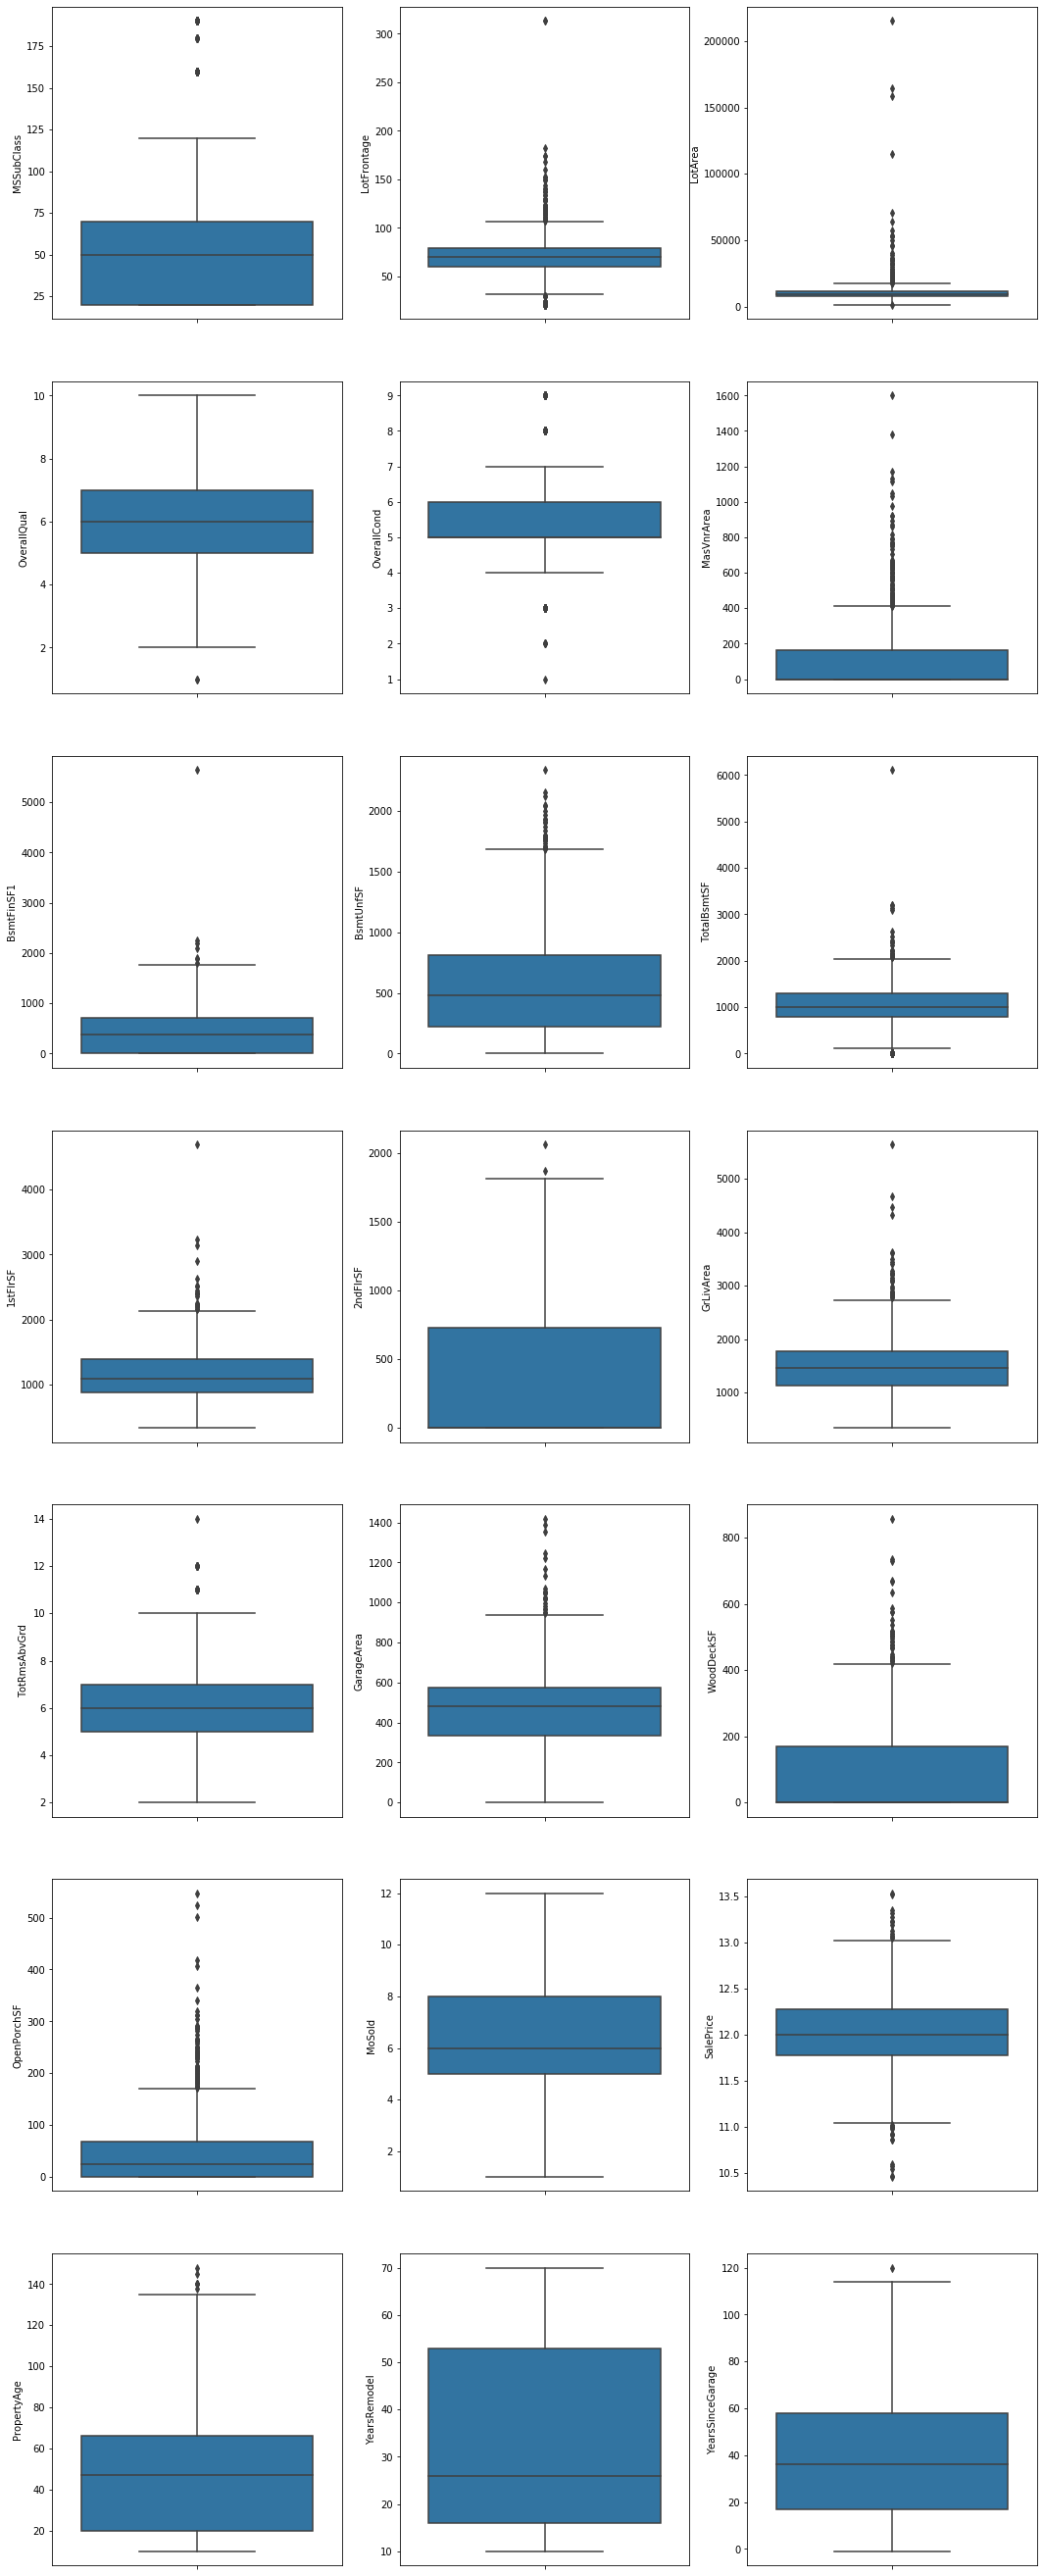

In [88]:
plt.figure(figsize=(18,48))
i=1
for col in columnsForOutliers:
    plt.subplot(7, 3, i)
    sns.boxplot(x=col, data=pricingInfo, orient='v')
    i=i+1

#### Observation 
Following columns might need outlier treatment
- LotArea
- TotalBsmtSF
- GrLivArea
- BsmtFinSF1
- OpenPorchSF

In [89]:
getOutlierCount(pricingInfo, 'LotArea')

Upper outliers:  13
Lower outliers:  0


In [90]:
#LotArea
pricingInfo = removeUpperOutlier(pricingInfo, 'LotArea')
pricingInfo.shape

(1446, 47)

In [91]:
getOutlierCount(pricingInfo, 'TotalBsmtSF')

Upper outliers:  10
Lower outliers:  0


In [92]:
#TotalBsmtSF
pricingInfo = removeUpperOutlier(pricingInfo, 'TotalBsmtSF')
pricingInfo.shape

(1436, 47)

In [93]:
getOutlierCount(pricingInfo, 'GrLivArea')

Upper outliers:  13
Lower outliers:  0


In [94]:
#TotalBsmtSF
pricingInfo = removeUpperOutlier(pricingInfo, 'GrLivArea')
pricingInfo.shape

(1423, 47)

In [95]:
pricingInfo['1stFlrSF'].describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1423.000000
mean     1141.773015
std       352.359912
min       334.000000
10%       756.000000
25%       876.000000
30%       912.000000
50%      1077.000000
75%      1362.500000
80%      1453.600000
90%      1650.200000
95%      1775.500000
97%      1877.440000
98%      2000.000000
100%     2898.000000
max      2898.000000
Name: 1stFlrSF, dtype: float64

In [96]:
getOutlierCount(pricingInfo, '1stFlrSF')

Upper outliers:  7
Lower outliers:  0


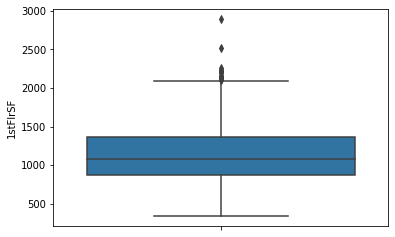

In [97]:
#1stFlrSF
sns.boxplot(x='1stFlrSF', data=pricingInfo, orient='v')

In [98]:
# % age of non zero values.
len(pricingInfo.loc[pricingInfo.WoodDeckSF>0].index)/len(pricingInfo.index)

0.47224174279690795

In [99]:
pricingInfo.shape

(1423, 47)

### Create dummy variables

In [100]:
catColumns = pricingInfo.select_dtypes('object')
catColumns

,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,YearsSinceLastSold
0,RL,Reg,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,Ex,1,2,1,3,Gd,0,NoFirePlace,Attchd,RFn,2,12
1,RL,Reg,FR2,Veenker,1Story,Gable,MetalSd,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,Ex,0,2,0,3,TA,1,TA,Attchd,RFn,2,13
2,RL,IR1,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,Ex,1,2,1,3,Gd,1,TA,Attchd,RFn,2,12
3,RL,IR1,Corner,Crawfor,2Story,Gable,Wd Sdng,Wd Shng,None,TA,BrkTil,TA,No,ALQ,Gd,1,1,0,3,Gd,1,Gd,Detchd,Unf,3,14
4,RL,IR1,FR2,NoRidge,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,Ex,1,2,1,4,Gd,1,TA,Attchd,RFn,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Reg,Inside,Gilbert,2Story,Gable,VinylSd,VinylSd,None,TA,PConc,Gd,No,Unf,Ex,0,2,1,3,TA,1,TA,Attchd,RFn,2,13
1456,RL,Reg,Inside,NWAmes,1Story,Gable,Plywood,Plywood,Stone,TA,CBlock,Gd,No,ALQ,TA,1,2,0,3,TA,2,TA,Attchd,Unf,2,10
1457,RL,Reg,Inside,Crawfor,2Story,Gable,CemntBd,CmentBd,None,Ex,Stone,TA,No,GLQ,Ex,0,2,0,4,Gd,2,Gd,Attchd,RFn,1,10
1458,RL,Reg,Inside,NAmes,1Story,Hip,MetalSd,MetalSd,None,TA,CBlock,TA,Mn,GLQ,Gd,1,1,0,2,Gd,0,NoFirePlace,Attchd,Unf,1,10


In [101]:
dummyDf = pd.get_dummies(catColumns, drop_first=True, prefix= catColumns.columns)
dummyDf

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,

In [102]:
pricingInfo2 = pd.concat([pricingInfo, dummyDf], join='inner', axis=1)
pricingInfo2

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,PropertyAge,YearsRemodel,YearsSinceLastSold,YearsSinceGarage,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
0,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,NoFirePlace,Attchd,RFn,2,548,0,61,2,12.247694,17,17,12,17,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,TA,Attchd,RFn,2,460,298,0,5,12.109011,44,44,13,44,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,

In [103]:
#drop original variable
pricingInfo2.drop(catColumns, axis=1, inplace=True)

In [104]:
y= pricingInfo2['SalePrice']
X = pricingInfo2.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,test_size = 0.3, random_state=100)

In [105]:
scaledColumns = pricingInfo2.select_dtypes(include=['int64', 'float64'])
scaledColumns.drop('SalePrice', axis=1, inplace=True) # we are not scaling the target variable. 

In [106]:
cols = scaledColumns.columns

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,test_size = 0.3, random_state=100)
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])

# scaling test data
X_test[cols] = scaler.transform(X_test[cols])
X_test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,PropertyAge,YearsRemodel,YearsSinceGarage,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
909,0.072401,3.886200,0.734773,-0.036489,-0.522883,-0.585700,-1.010093,0.408918,-0.741812,-1.120967,0.995513,0.025924,1.015208,-0.371151,-0.448290,-0.320333,-0.093777,-1.121875,-0.973728,-0.932069,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1038,2.440602,-2.349364,-2.018623,-1.519859,0.387591,-0.585700,-1.010093,-0.036868,-1.242755,-0.962541,0.522625,-0.281645,-0.276993,-2.277856,-0.744375,-0.676368,-0.464418,0.061261,-1.117933,-1.564399,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
420,0.782862,0.427411,-0.642174,0.705197,-0.522883,0.673476,2.130552,-1.199096,0.796798,0.582115,-0.794707,-0.281645,1.015208,1.555110,-0.744375,-0.676368,1.759428,-0.851444,-0.637247,-0.615903,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0

### Ridge Regression

In [107]:
# Running RFE with the output number of the variable equal to 80
rdg =  Ridge()
rdg.fit(X_train, y_train)

rfe_ridge = RFE(rdg, 80)             # running RFE
rfe_ridge = rfe_ridge.fit(X_train, y_train)

In [108]:
ridge_cols = X_train.columns[rfe_ridge.support_]
ridge_cols

Index(['LotArea', 'OverallQual', 'OverallCond', 'BsmtUnfSF', 'TotalBsmtSF',
       'GrLivArea', 'PropertyAge', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'LotConfig_FR2', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Veenker', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofStyle_Mansard', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_ImStucc', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior2nd_BrkFace', 'Exterior2nd_ImStucc',
       'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
       'MasVnrType_BrkFace', 'MasV

In [109]:
# list of alphas to tune
alpha_ridge = np.linspace(0.01,10, 1000)
params_ridge = {'alpha':alpha_ridge}

X_train_ridge_rfe = X_train[ridge_cols]
ridge = Ridge()

# cross validation
ridge_folds = 5
model_cv_ridge = GridSearchCV(estimator = ridge, 
                        param_grid = params_ridge, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = ridge_folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv_ridge.fit(X_train_ridge_rfe, y_train) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   25.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0....
        9.46,  9.47,  9.48,  9.49,  9.5 ,  9.51,  9.52,  9.53,  9.54,
        9.55,  9.56,  9.57,  9.58,  9.59,  9.6 ,  9.61,  9.62,  9.63,
        9.64,  9.65,  9.66,  9.67,  9.68,  9.69,  9.7 ,  9.71,  9.72,
        9.73,  9.74,  9.75,  9.76,  9.77,  9.78,  9.79,  9.8 ,  9.81,
        9.82,  9.83,  9.84,  9.85,  9.86,  9.87,  9.88,  9.89,  9.9 ,
        9.91,  9.92,  9.93,  9.94,  9.95,  9.96,  9.97,  9.98,  9.99,
       10.  ])},
             pre_dispatch='2*n

In [110]:
cv_results_ridge = pd.DataFrame(model_cv_ridge.cv_results_)
# cv_results = cv_results[cv_results['param_alpha']<=10]
cv_results_ridge

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003593,0.001020,0.001195,0.000747,0.01,{'alpha': 0.01},-0.086577,-0.081580,-0.085684,-0.080776,-0.078126,-0.082548,0.003153,1000,-0.070594,-0.070310,-0.071003,-0.071094,-0.072670,-0.071134,0.000818
1,0.004189,0.000747,0.001601,0.000493,0.02,{'alpha': 0.02},-0.086618,-0.081574,-0.085605,-0.080735,-0.077896,-0.082486,0.003218,999,-0.070590,-0.070325,-0.071010,-0.071103,-0.072686,-0.071143,0.000821
2,0.003790,0.000402,0.001196,0.000400,0.03,{'alpha': 0.03},-0.086661,-0.081568,-0.085528,-0.080695,-0.077677,-0.082426,0.003281,998,-0.070585,-0.070340,-0.071022,-0.071112,-0.072705,-0.071153,0.000826
3,0.004388,0.000798,0.001596,0.000489,0.04,{'alpha': 0.04},-0.086701,-0.081563,-0.085453,-0.080656,-0.077470,-0.082369,0.003343,997,-0.070580,-0.070355,-0.071036,-0.071122,-0.072725,-0.071163,0.000831
4,0.004190,0.000399,0.001397,0.000487,0.05,{'alpha': 0.05},-0.086739,-0.081558,-0.085380,-0.080618,-0.077282,-0.082315,0.003399,996,-0.070576,-0.070370,-0.071049,-0.071131,-0.072745,-0.071174,0.000836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.002002,0.000014,0.000997,0.000003,9.96,{'alpha': 9.96},-0.084650,-0.082338,-0.079791,-0.083444,-0.079351,-0.081915,0.002053,983,-0.075280,-0.075232,-0.076536,-0.075591,-0.077301,-0.075988,0.000807
996,0.002001,0.000016,0.001102,0.000207,9.97,{'alpha': 9.97},-0.084649,-0.082339,-0.079792,-0.083447,-0.079353,-0.081916,0.002053,984,-0.075283,-0.075234,-0.076538,-0.075593,-0.077303,-0.075990,0.000807
997,0.002596,0.000481,0.000902,0.000659,9.98,{'alpha': 9.98},-0.084648,-0.082340,-0.079792,-0.083449,-0.079355,-0.081917,0.002052,985,-0.075286,-0.075236,-0.076541,-0.075595,-0.077305,-0.075993,0.000807
998,0.003593,0.000491,0.001197,0.000399,9.99,{'alpha': 9.99},-0.084647,-0.082340,-0.079793,-0.083452,-0.079357,-0.081918,0.002052,986,-0.075288,-0.075238,-0.076543,-0.075597,-0.077307,-0.075995,0.000806


In [111]:
model_cv_ridge.best_estimator_

Ridge(alpha=1.8800000000000001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

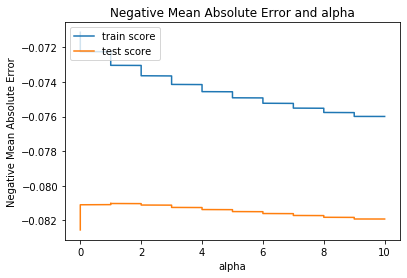

In [112]:
# plotting mean test and train scoes with alpha 
cv_results_ridge['param_alpha'] = cv_results_ridge['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_train_score'])
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [113]:
alpha_final =  model_cv_ridge.best_estimator_.alpha  #alpha form the best estimator
finalRidge = Ridge(alpha=alpha_final)

finalRidge.fit(X_train_ridge_rfe, y_train)
finalRidge.coef_

array([ 0.02325579,  0.06645983,  0.05989189, -0.03127895,  0.07027753,
        0.12362425, -0.08418544,  0.17620115,  0.07971753,  0.14774567,
        0.109803  , -0.02692071, -0.02837523, -0.08369867,  0.02329295,
        0.09194868, -0.03753185, -0.07855689, -0.12233715, -0.04264589,
        0.02288515,  0.0526703 , -0.06522554,  0.0303266 ,  0.10924774,
        0.02850779,  0.02812998, -0.0418899 ,  0.10845662,  0.02583318,
        0.06743837,  0.02519451,  0.06627355,  0.03901762,  0.09438338,
        0.01271044,  0.04965537, -0.04805529, -0.02574774, -0.03949016,
       -0.08048494, -0.04194981,  0.05528495,  0.03731631,  0.0321516 ,
        0.05114777, -0.03259449,  0.05033325, -0.02194852, -0.04153466,
       -0.04980103,  0.05101168, -0.05367396, -0.03944767, -0.03869215,
       -0.03135699,  0.02144882,  0.10986487,  0.09346237,  0.03715583,
        0.02411335,  0.07678446, -0.05388798, -0.05147053, -0.06836484,
       -0.09263968, -0.06487693, -0.07674282, -0.02335659, -0.04

In [114]:

#train predict
y_train_pred_ridge = finalRidge.predict(X_train_ridge_rfe)
#test predict
y_pred_ridge = finalRidge.predict(X_test[ridge_cols])


print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_ridge))

print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_ridge))

print('train ridge score')
print(finalRidge.score(X_train_ridge_rfe, y_train_pred_ridge))

print('test ridge score')
print(finalRidge.score(X_test[ridge_cols], y_test))


train r2 score
0.9261861168103441
Test r2 score
0.8952228048008736
train ridge score
1.0
test ridge score
0.8952228048008736


In [115]:
ridge_df = pd.DataFrame({"column":X_train_ridge_rfe.columns, 'Coeff': finalRidge.coef_})
ridge_df['absCoeff'] = ridge_df['Coeff'].abs()
ridge_df.sort_values(by='absCoeff', ascending=False)

,column,Coeff,absCoeff
7,MSZoning_FV,0.176201,0.176201
9,MSZoning_RL,0.147746,0.147746
5,GrLivArea,0.123624,0.123624
18,Neighborhood_MeadowV,-0.122337,0.122337
57,BsmtFullBath_2,0.109865,0.109865
...,...,...,...
0,LotArea,0.023256,0.023256
20,Neighborhood_NoRidge,0.022885,0.022885
48,Foundation_Wood,-0.021949,0.021949
56,BsmtFullBath_1,0.021449,0.021449


#### For subjective question 1

In [116]:
alpha_final =  model_cv_ridge.best_estimator_.alpha*2  #alpha form the best estimator * 2
print(alpha_final)
finalRidge2 = Ridge(alpha=alpha_final)

finalRidge2.fit(X_train_ridge_rfe, y_train)

3.7600000000000002


Ridge(alpha=3.7600000000000002, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [117]:
y_pred_ridge2 = finalRidge2.predict(X_test[ridge_cols])

print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_ridge))

print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_ridge2))

print('train ridge score')
print(finalRidge2.score(X_train[ridge_cols], y_train_pred_ridge))

print('test ridge score')
print(finalRidge2.score(X_test[ridge_cols], y_test))


train r2 score
0.9261861168103441
Test r2 score
0.8958677920619135
train ridge score
0.9996461850435909
test ridge score
0.8958677920619135


In [118]:
df = pd.DataFrame({"column":X_train_ridge_rfe.columns, 'Coeff': finalRidge2.coef_})
df['absCoeff'] = df['Coeff'].abs()
df.sort_values(by='absCoeff', ascending=False).head(5)

,column,Coeff,absCoeff
5,GrLivArea,0.123054,0.123054
7,MSZoning_FV,0.122150,0.122150
9,MSZoning_RL,0.100684,0.100684
18,Neighborhood_MeadowV,-0.099151,0.099151
24,Neighborhood_StoneBr,0.096425,0.096425


## Lasso

In [119]:
# Running RFE with the output number of the variable equal to 10
las =  Lasso()
las.fit(X_train, y_train)

rfe_lasso = RFE(las, 50)             # running RFE
rfe_lasso = rfe_lasso.fit(X_train, y_train)

In [120]:
col_lasso = X_train.columns[rfe_lasso.support_]

In [121]:
lasso = Lasso()
X_train_rfe_lasso = X_train[col_lasso]
alpha_lasso = np.linspace(0.0001, 0.001, 1000)
# alpha_lasso = [0.0001,0.001, 0.01, 0.05, 0.1,  0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,  4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]

params_lasso={'alpha':alpha_lasso}

folds_lasso=5
# cross validation
model_cv_lasso = GridSearchCV(estimator = lasso, 
                        param_grid = params_lasso, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds_lasso, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_lasso.fit(X_train_rfe_lasso, y_train) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   50.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.0001    , 0.0001009 , 0.0001018 , 0.0001027 , 0.0001036 ,
       0.0001045 , 0.00010541, 0.00010...
       0.00097838, 0.00097928, 0.00098018, 0.00098108, 0.00098198,
       0.00098288, 0.00098378, 0.00098468, 0.00098559, 0.00098649,
       0.00098739, 0.00098829, 0.00098919, 0.00099009, 0.00099099,
       0.00099189, 0.00099279, 0.00099369, 0.00099459, 0.0009955 ,
       0.0009964 , 0.0009973 , 0.0009982 , 0.0009991 , 0.001     ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [122]:
model_cv_lasso.best_estimator_

Lasso(alpha=0.0001954954954954955, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [123]:
cv_results_lasso = pd.DataFrame(model_cv_lasso.cv_results_)
# cv_results = cv_results[cv_results['param_alpha']<=.1]
cv_results_lasso.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.016628,0.004911,0.000998,6.572747e-07,0.0001,{'alpha': 0.0001},-0.144735,-0.130864,-0.131159,-0.126883,-0.135095,-0.133747,0.006077,141,-0.122750,-0.125263,-0.125612,-0.128892,-0.124842,-0.125472,0.001978
1,0.020048,0.006428,0.001596,4.895521e-04,0.000100901,{'alpha': 0.0001009009009009009},-0.144750,-0.130870,-0.131153,-0.126869,-0.135089,-0.133746,0.006086,135,-0.122755,-0.125265,-0.125616,-0.128894,-0.124846,-0.125475,0.001977
2,0.017553,0.003867,0.001245,3.862772e-04,0.000101802,{'alpha': 0.0001018018018018018},-0.144766,-0.130875,-0.131148,-0.126854,-0.135093,-0.133747,0.006095,140,-0.122760,-0.125268,-0.125620,-0.128896,-0.124849,-0.125479,0.001976
3,0.015632,0.002439,0.000797,3.987335e-04,0.000102703,{'alpha': 0.0001027027027027027},-0.144781,-0.130881,-0.131137,-0.126840,-0.135096,-0.133747,0.006104,139,-0.122765,-0.125270,-0.125623,-0.128898,-0.124852,-0.125482,0.001975
4,0.022574,0.005623,0.001195,3.992090e-04,0.000103604,{'alpha': 0.00010360360360360361},-0.144797,-0.130887,-0.131126,-0.126825,-0.135100,-0.133747,0.006114,138,-0.122772,-0.125273,-0.125627,-0.128900,-0.124856,-0.125485,0.001974


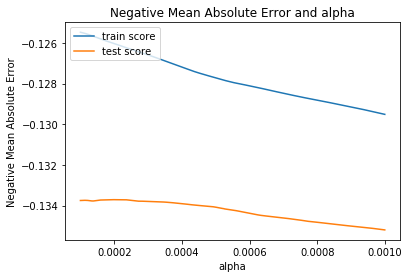

In [124]:
# plotting mean test and train scoes with alpha 
cv_results_lasso['param_alpha'] = cv_results_lasso['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_train_score'])
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_test_score'])
plt.xlabel('alpha')
# plt.xscale('log')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [125]:
alpha_lasso =model_cv_lasso.best_estimator_.alpha

final_lasso = Lasso(alpha=alpha_lasso)
       
final_lasso.fit(X_train_rfe_lasso, y_train) 

Lasso(alpha=0.0001954954954954955, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [126]:
y_pred_lasso = final_lasso.predict(X_test[col_lasso])
y_train_pred_lasso = final_lasso.predict(X_train[col_lasso])


print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_lasso))

print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_lasso))

print('train lasso score')
print(final_lasso.score(X_train[col_lasso], y_train_pred_lasso))

print('test lasso score')
print(final_lasso.score(X_test[col_lasso], y_test))


train r2 score
0.7989053061163593
Test r2 score
0.7724650988505499
train lasso score
1.0
test lasso score
0.7724650988505499


In [169]:
final_lasso_df = pd.DataFrame({"column":X_train_rfe_lasso.columns, 'Coeff': final_lasso.coef_}).sort_values(by='Coeff')
final_lasso_df['absCoeff'] = final_lasso_df['Coeff'].abs()
final_lasso_df.sort_values(by='absCoeff', ascending=False, inplace=True)
final_lasso_df

array(['FullBath_3', 'KitchenQual_Fa', 'KitchenQual_TA', 'FullBath_2',
       'BsmtFullBath_2'], dtype=object)

#### For subjective question 1

In [128]:
alpha_lasso =model_cv_lasso.best_estimator_.alpha*2
print(alpha_lasso)
final_lasso2 = Lasso(alpha=alpha_lasso)
final_lasso2.fit(X_train_rfe_lasso, y_train) 
final_lasso2.coef_

0.000390990990990991


array([-0.00000000e+00, -2.06195476e-01, -3.01286067e-02, -7.16788407e-02,
       -1.00815577e-01, -4.26978294e-02, -0.00000000e+00, -8.79050962e-02,
        6.01349121e-02,  1.98129217e-01,  0.00000000e+00,  4.24580436e-02,
        1.71235643e-01,  4.20866797e-01,  6.19454176e-02,  3.20513278e-02,
       -1.95526509e-01, -6.74112531e-02, -1.64263223e-02,  2.86015832e-02,
        0.00000000e+00,  1.05716870e-01, -4.29910064e-01, -2.16163906e-01,
       -3.25335327e-01, -3.32559283e-06,  6.74793509e-02,  2.04626476e-03,
       -5.53875309e-02,  0.00000000e+00, -1.35943485e-01, -4.74857081e-02,
       -3.10090835e-02,  1.32379087e-01,  0.00000000e+00,  7.44150559e-02,
       -2.52167321e-02,  6.04079506e-02, -2.46545507e-01, -9.82053851e-15,
       -2.52147169e-04, -7.27473771e-02, -1.05080831e-01,  0.00000000e+00,
        1.96341597e-01,  0.00000000e+00, -0.00000000e+00,  1.28249844e-02,
        1.13801928e-02,  0.00000000e+00])

In [129]:
y_pred_lasso2 = final_lasso2.predict(X_test[col_lasso])
y_train_pred_lasso2 = final_lasso2.predict(X_train_rfe_lasso)
print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_lasso))

print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_lasso))

print('train lasso score')
print(final_lasso.score(X_train[col_lasso], y_train_pred_lasso))

print('test lasso score')
print(final_lasso.score(X_test[col_lasso], y_test))

train r2 score
0.7989053061163593
Test r2 score
0.7724650988505499
train lasso score
1.0
test lasso score
0.7724650988505499


In [130]:
df= pd.DataFrame({"column":X_train_rfe_lasso.columns, 'Coeff': final_lasso2.coef_}).sort_values(by='Coeff')

df['absCoeff'] = df['Coeff'].abs()
df = df.sort_values(by='absCoeff', ascending=False)
df[(df.absCoeff>0)]

,column,Coeff,absCoeff
22,KitchenQual_Fa,-4.299101e-01,4.299101e-01
13,FullBath_3,4.208668e-01,4.208668e-01
24,KitchenQual_TA,-3.253353e-01,3.253353e-01
38,GarageType_NoGarage,-2.465455e-01,2.465455e-01
23,KitchenQual_Gd,-2.161639e-01,2.161639e-01
1,BsmtFinType1_NoBasement,-2.061955e-01,2.061955e-01
9,BsmtFullBath_2,1.981292e-01,1.981292e-01
44,GarageCars_3,1.963416e-01,1.963416e-01
16,BedroomAbvGr_1,-1.955265e-01,1.955265e-01
12,FullBath_2,1.712356e-01,1.712356e-01


## For subjective question 2

In [170]:
# pricingInfo3 = pricingInfo.drop(['KitchenQual','FullBath', 'BsmtFullBath' ], axis=1)
pricingInfo3 = pricingInfo

In [171]:
catColumns3 = pricingInfo3.select_dtypes('object')
catColumns3

,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,YearsSinceLastSold
0,RL,Reg,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,Ex,1,2,1,3,Gd,0,NoFirePlace,Attchd,RFn,2,12
1,RL,Reg,FR2,Veenker,1Story,Gable,MetalSd,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,Ex,0,2,0,3,TA,1,TA,Attchd,RFn,2,13
2,RL,IR1,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,Ex,1,2,1,3,Gd,1,TA,Attchd,RFn,2,12
3,RL,IR1,Corner,Crawfor,2Story,Gable,Wd Sdng,Wd Shng,None,TA,BrkTil,TA,No,ALQ,Gd,1,1,0,3,Gd,1,Gd,Detchd,Unf,3,14
4,RL,IR1,FR2,NoRidge,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,Ex,1,2,1,4,Gd,1,TA,Attchd,RFn,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Reg,Inside,Gilbert,2Story,Gable,VinylSd,VinylSd,None,TA,PConc,Gd,No,Unf,Ex,0,2,1,3,TA,1,TA,Attchd,RFn,2,13
1456,RL,Reg,Inside,NWAmes,1Story,Gable,Plywood,Plywood,Stone,TA,CBlock,Gd,No,ALQ,TA,1,2,0,3,TA,2,TA,Attchd,Unf,2,10
1457,RL,Reg,Inside,Crawfor,2Story,Gable,CemntBd,CmentBd,None,Ex,Stone,TA,No,GLQ,Ex,0,2,0,4,Gd,2,Gd,Attchd,RFn,1,10
1458,RL,Reg,Inside,NAmes,1Story,Hip,MetalSd,MetalSd,None,TA,CBlock,TA,Mn,GLQ,Gd,1,1,0,2,Gd,0,NoFirePlace,Attchd,Unf,1,10


In [172]:
dummyDf3 = pd.get_dummies(catColumns3, drop_first=True, prefix= catColumns3.columns)
dummyDf3

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,

In [173]:
pricingInfo4 = pd.concat([pricingInfo3, dummyDf3], join='inner', axis=1)
pricingInfo4

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,PropertyAge,YearsRemodel,YearsSinceLastSold,YearsSinceGarage,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
0,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,NoFirePlace,Attchd,RFn,2,548,0,61,2,12.247694,17,17,12,17,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,TA,Attchd,RFn,2,460,298,0,5,12.109011,44,44,13,44,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,

In [174]:
#drop original variable
pricingInfo4.drop(catColumns3, axis=1, inplace=True)

In [175]:
# drop top variables from previous selected model
top5 = final_lasso_df[:5]['column'].values
pricingInfo4.drop(top5, inplace=True, axis=1)

In [176]:
y= pricingInfo4['SalePrice']
X = pricingInfo4.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,test_size = 0.3, random_state=100)

In [177]:
scaledColumns = pricingInfo4.select_dtypes(include=['int64', 'float64'])
scaledColumns.drop('SalePrice', axis=1, inplace=True) # we are not scaling the target variable. 

In [178]:
cols = scaledColumns.columns

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])

# scaling test data
X_test[cols] = scaler.transform(X_test[cols])
X_test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,PropertyAge,YearsRemodel,YearsSinceGarage,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_3,FullBath_1,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Gd,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
909,0.072401,3.886200,0.734773,-0.036489,-0.522883,-0.585700,-1.010093,0.408918,-0.741812,-1.120967,0.995513,0.025924,1.015208,-0.371151,-0.448290,-0.320333,-0.093777,-1.121875,-0.973728,-0.932069,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1038,2.440602,-2.349364,-2.018623,-1.519859,0.387591,-0.585700,-1.010093,-0.036868,-1.242755,-0.962541,0.522625,-0.281645,-0.276993,-2.277856,-0.744375,-0.676368,-0.464418,0.061261,-1.117933,-1.564399,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
420,0.782862,0.427411,-0.642174,0.705197,-0.522883,0.673476,2.130552,-1.199096,0.796798,0.582115,-0.794707,-0.281645,1.015208,1.555110,-0.744375,-0.676368,1.759428,-0.851444,-0.637247,-0.615903,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

In [179]:
print(X_train.shape)
print(X_test.shape)

(996, 162)
(427, 162)


In [180]:
# Running RFE with the output number of the variable equal to 10
# Running RFE with the output number of the variable equal to 10
las3 =  Lasso()
las3.fit(X_train, y_train)

rfe_lasso3 = RFE(las3, 50)             # running RFE
rfe_lasso3 = rfe_lasso3.fit(X_train, y_train)

lasso_cols = X_train.columns[rfe_lasso3.support_]

In [181]:
# list of alphas to tune

X_train_rfe_lasso3 = X_train[lasso_cols]
lasso3 = Lasso()
alpha_lasso3 = np.linspace(0.0001, 0.001, 1000)
params_lasso3 = {'alpha':alpha_lasso3}

# cross validation
lass_folds3 = 5
model_cv_lasso3 = GridSearchCV(estimator = lasso3, 
                        param_grid = params_lasso3, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = lass_folds3, 
                        return_train_score=True,
                        verbose = 1)            
model_cv_lasso3.fit(X_train_rfe_lasso3, y_train) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   33.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.0001    , 0.0001009 , 0.0001018 , 0.0001027 , 0.0001036 ,
       0.0001045 , 0.00010541, 0.00010...
       0.00097838, 0.00097928, 0.00098018, 0.00098108, 0.00098198,
       0.00098288, 0.00098378, 0.00098468, 0.00098559, 0.00098649,
       0.00098739, 0.00098829, 0.00098919, 0.00099009, 0.00099099,
       0.00099189, 0.00099279, 0.00099369, 0.00099459, 0.0009955 ,
       0.0009964 , 0.0009973 , 0.0009982 , 0.0009991 , 0.001     ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [182]:
model_cv_lasso3.best_estimator_

Lasso(alpha=0.00012972972972972974, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [183]:
cv_results_lasso3 = pd.DataFrame(model_cv_lasso3.cv_results_)
# cv_results_lasso3

In [184]:
alpha_final_lasso3 =  model_cv_lasso3.best_estimator_.alpha  #alpha form the best estimator
finalLasso3 =Lasso(alpha=alpha_final_lasso3)

finalLasso3.fit(X_train_rfe_lasso3, y_train)

#train predict
y_train_pred_lasso3 = finalLasso3.predict(X_train_rfe_lasso3)
#test predict
y_pred_lasso3 = finalLasso3.predict(X_test[lasso_cols])


print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_lasso3))
print('train ridge score')
print(finalLasso3.score(X_train_rfe_lasso3, y_train_pred_lasso3))


print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_lasso3))
print('test ridge score')
print(finalLasso3.score(X_test[lasso_cols], y_test))

lassoCoeff3 = pd.DataFrame({"column":X_train_rfe_lasso3.columns, 'Coeff': finalLasso3.coef_})
lassoCoeff3['absCoeff'] = lassoCoeff3['Coeff'].abs()
lassoCoeff3.sort_values(by='absCoeff', ascending=False)

train r2 score
0.7674444716162616
train ridge score
1.0
Test r2 score
0.7650944587683454
test ridge score
0.7650944587683454


,column,Coeff,absCoeff
11,HeatingQC_Po,-3.159243e-01,3.159243e-01
14,BsmtFullBath_3,3.146779e-01,3.146779e-01
30,FireplaceQu_NoFirePlace,-3.137049e-01,3.137049e-01
38,GarageType_NoGarage,-2.605061e-01,2.605061e-01
28,FireplaceQu_Fa,-2.411154e-01,2.411154e-01
31,FireplaceQu_Po,-2.402282e-01,2.402282e-01
18,BedroomAbvGr_1,-2.338761e-01,2.338761e-01
44,GarageCars_3,2.327402e-01,2.327402e-01
32,FireplaceQu_TA,-2.191325e-01,2.191325e-01
23,BedroomAbvGr_6,1.963271e-01,1.963271e-01
